# SAAS <> Media Matters Worldwide Media Mix Model and Budget Optimizer

This notebook contains a media mix model, created from methods similar to __[this paper](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/46001.pdf)__. The model informs a budget optimizer, which optimizes the budget for spending in advertising media channels in the short-term.

There are 4 sections in this notebook.

1. [Data Collection](#data-collection)
2. [Data Preprocessing](#data-preprocessing)
3. [Modeling](#modeling)
4. [Optimization](#optimize)

> Run a notebook-cell by clicking a cell and pressing ctrl-enter (windows) or  (equivalent on mac). Alternatively, after selecting a cell, hit the play button in the navigation bar at the top

> Don't modify the code in any cell unless explicitly prompted to do so.     

***

Replace the `client` variable with the client's name. The client's name should be surrounded by double quotations.

In [2]:
client = "MHW"

Run the following three cells to import the necessary packages

In [3]:
import warnings
warnings.filterwarnings(action='ignore')

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score 
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

from datetime import datetime as dt
from functools import reduce
from yellowbrick.regressor import residuals_plot
from transformations import transform_one_column, select_best_feature, feature_imp_random_forest

import time
import datetime
import ipywidgets as widgets
from ipywidgets import FileUpload

from IPython.display import display
from IPython.display import FileLink
import io
import re
from scipy.optimize import minimize, LinearConstraint

import holidays

import panel as pn
pn.extension()

In [5]:
from v4_helper import *

In [6]:
# COMMANDS I RAN TO GET FILEUPLOAD AND JUPYTERWIDGETS TO LOAD
# !jupyter nbextension enable --py widgetsnbextension
# !pip install jupyterlab-widgets
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager
# uf = upload.value[list(upload.value.keys())[0]]['content']

***

<a id="data-collection"></a> 
# Data Collection

<div class="alert alert-block alert-info">
<b>Note: </b>The notebook is only compatible with two file formats: .csv and .xlsx.</div>

## 1A: Input Data - Sales

Set the `use_excel` variable in the next cell to `False` if you are inputting a `.csv` file; if you are inputting a `xlsx`, leave as `True` .
Set the `granularity` variable in the next cell to `False` if the granularity (what each row in the data represents) is weekly; if daily, leave as `True`.
> The granularity of the sales data must be the same as the granularity of the advertising mix data

In [7]:
use_excel = True
granularity = True
data_type = "SALES DATA"

***

### step 1: attach file

The next cell will take you through the steps to input the data. Don't modify any of the parameters (`data_type` and `use_excel`) in the cell.
After running the cell, an *Upload* Button will pop up. Click the *Upload* Button, navigate to the folder on your computer that contains the sales data, and attach the proper file. Once you upload the *sales data*, the number next to *Upload* should change from 0 to 1. If so, proceed by running the next cell.

> The *Upload* widget will only recognize and look for .csv or .xlsx formats.

In [8]:
df_as_bytes = input_file(data_type, use_excel=use_excel)

FileUpload(value={}, accept='.xlsx', description='Upload')

***

### step 2: parse sales data

Now that you've attached the sales data, the notebook will need to parse the data from the *Upload* Button. 
After running the cell, the notebook will display the sales data in a table. 
The following cell will ask you the following questions regarding the format of the data.

1. Is the header, as displayed, of the dataframe correct? [y/n] If no, which row contains the header (zero-indexed)?
2. Is the SALES DATA file good to go? [y/n]

`y` corresponds to yes, and `n` corresponds to no. `zero-indexed` is a way of numbering in which the initial element of a sequence is assigned the index 0, rather than 1.

In [9]:
sales_df = parse_file(df_as_bytes, data_type, use_excel=use_excel)

Thanks for uploading the SALES DATA. I will display the dataframe in 2 seconds


,Date Range:,01-Jan-2019 - 31-Oct-2021,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,NaN,NaN,NaN,NaN,NaN,NaN
1,Day,Market,Visits,Orders,Order Rate,Revenue
2,2021-10-31 00:00:00,CA,2046,35,0.017107,11094.06
3,2021-10-31 00:00:00,US,17085,366,0.021422,68893.79
4,2021-10-30 00:00:00,US,17415,384,0.02205,74587.9
...,...,...,...,...,...,...
2067,2019-01-03 00:00:00,CA,1562,20,0.012804,3086.61
2068,2019-01-02 00:00:00,CA,1643,7,0.00426,2314.75
2069,2019-01-02 00:00:00,US,14149,118,0.00834,29352.76
2070,2019-01-01 00:00:00,CA,1404,8,0.005698,1288.42


Is the header correct [y/n]n
Specify which row contains the header (zero-indexed)1


1,Day,Market,Visits,Orders,Order Rate,Revenue
2,2021-10-31 00:00:00,CA,2046,35,0.017107,11094.06
3,2021-10-31 00:00:00,US,17085,366,0.021422,68893.79
4,2021-10-30 00:00:00,US,17415,384,0.02205,74587.9
5,2021-10-30 00:00:00,CA,2079,30,0.01443,8474.75
6,2021-10-29 00:00:00,CA,1942,24,0.012358,9733.25
...,...,...,...,...,...,...
2067,2019-01-03 00:00:00,CA,1562,20,0.012804,3086.61
2068,2019-01-02 00:00:00,CA,1643,7,0.00426,2314.75
2069,2019-01-02 00:00:00,US,14149,118,0.00834,29352.76
2070,2019-01-01 00:00:00,CA,1404,8,0.005698,1288.42


Type the letter y if the SALES DATA file is good to go, OR the letter n if you'd like to reupload
proceed [y/n]y
SUCCESS -- PROCEED


***

### step 3: clean sales data

After running the cell, the notebook will display a list of the column-names of the sales data.

This cell asks you to identify the different countries or regions represented in the data, identify which column corresponds to the (day/week) and identify which column corresponds to the target or dependent variable (revenue/orders).

> Type each column name exactly as it is displayed, without quotations

In [10]:
sales_df_cleaned = clean_sales(sales_df, data_type, granularity=granularity)

COLUMNS of SALES DATA: ['Day' 'Market' 'Visits' 'Orders' 'Order Rate' 'Revenue']
If SALES DATA has more than one country that you'd like to segment and analyze separately, type the name of the column
If not, type NONE in that exact format
[column-name/NONE]Market
Which column corresponds to the day
[column-name]Day
Which column corresponds to the target/response/dependent variable? In most cases, this will be REVENUE or something similar
[column-name]Revenue


***

This process will be repeated for the advertising media mix data.

## 1B: Input Data - Ad Mix

Now that you've uploaded the sales data, the notebook requires advertising mix data.
Set the `use_excel` variable in the next cell to `False` if you are inputting a .csv file; if not, leave as `True`.

> The granularity of this data must be the same granularity of the sales data.

In [11]:
use_excel = True

***

### step 1: input ad data

In [12]:
data_type = "AD DATA"

In [13]:
ad_df_as_bytes = input_file(data_type, use_excel=use_excel)

FileUpload(value={}, accept='.xlsx', description='Upload')

***

### step 2: parse ad data

Now that you've attached the ad data, like before, the notebook will need to parse the data from the *Upload* Button. 
After running the cell, the notebook will display the ad data in a table. 
The following questions regarding the format of the data will be asked.

1. Is the header, as displayed, of the dataframe correct? [y/n] If no, which row contains the header (zero-indexed)?
2. Is the ad mix data file good to go? [y/n]

`y` corresponds to yes, and `n` corresponds to no. `zero-indexed` is a way of numbering in which the initial element of a sequence is assigned the index 0, rather than 1.

In [14]:
ad_df = parse_file(ad_df_as_bytes, data_type, use_excel=use_excel)

Thanks for uploading the AD DATA. I will display the dataframe in 2 seconds


,Date Range:,01-Jan-2019 - 31-Oct-2021,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Day,Market,Channel,Publisher,Media Objective,Ad Type,Strategy,Media Cost,Impressions,Clicks,Orders,Revenue
2,2021-10-31 00:00:00,US,Paid Social,Facebook,Retargeting,Carousel,purchase,8.87,351,2,8,1860.94
3,2021-10-31 00:00:00,Canada,Paid Social,Facebook,Prospecting,Display,lookalikepurchasers01,6.419997,740,4,0,0
4,2021-10-31 00:00:00,US,Display,AXM,Retargeting,Native,Native,44.67,2871,1,5,690.66
...,...,...,...,...,...,...,...,...,...,...,...,...
41269,2019-01-01 00:00:00,US,Paid Search,Search,Prospecting,Search,Brand Search,164.638643,6318,308,15,2665.4
41270,2019-01-01 00:00:00,US,Paid Social,Facebook,Prospecting,Display,camping,60.14,23669,37,0,0
41271,2019-01-01 00:00:00,US,Paid Social,Facebook,Prospecting,Video,rock climbing equipment,10.85,1660,3,0,0
41272,2019-01-01 00:00:00,Canada,Paid Social,Facebook,Prospecting,Display,climbing,95.54,28258,121,1,36.39


Is the header correct [y/n]n
Specify which row contains the header (zero-indexed)1


1,Day,Market,Channel,Publisher,Media Objective,Ad Type,Strategy,Media Cost,Impressions,Clicks,Orders,Revenue
2,2021-10-31 00:00:00,US,Paid Social,Facebook,Retargeting,Carousel,purchase,8.87,351,2,8,1860.94
3,2021-10-31 00:00:00,Canada,Paid Social,Facebook,Prospecting,Display,lookalikepurchasers01,6.419997,740,4,0,0
4,2021-10-31 00:00:00,US,Display,AXM,Retargeting,Native,Native,44.67,2871,1,5,690.66
5,2021-10-31 00:00:00,US,Paid Social,Facebook,Prospecting,Carousel,outlet,18.18,1396,21,0,0
6,2021-10-31 00:00:00,Canada,Display,AXM,Prospecting,Display,Audience,49.96,22548,35,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
41269,2019-01-01 00:00:00,US,Paid Search,Search,Prospecting,Search,Brand Search,164.638643,6318,308,15,2665.4
41270,2019-01-01 00:00:00,US,Paid Social,Facebook,Prospecting,Display,camping,60.14,23669,37,0,0
41271,2019-01-01 00:00:00,US,Paid Social,Facebook,Prospecting,Video,rock climbing equipment,10.85,1660,3,0,0
41272,2019-01-01 00:00:00,Canada,Paid Social,Facebook,Prospecting,Display,climbing,95.54,28258,121,1,36.39


Type the letter y if the AD DATA file is good to go, OR the letter n if you'd like to reupload
proceed [y/n]y
SUCCESS -- PROCEED


***

### step 3: clean ad mix data and merge with sales data

After running the cell, the notebook will display a list of the column-names of the ad mix data. This cell asks you to identify the column in the ad data corresponding to the country/region, media cost, and impressions.

The output of this cell, `data_dict`, is a dictionary mapping country name to its corresponding data matrix.

In [16]:
data_dict = clean_and_merge(ad_df, sales_df_cleaned)

['Day' 'Market' 'Channel' 'Publisher' 'Media Objective' 'Ad Type'
 'Strategy' 'Media Cost' 'Impressions' 'Clicks' 'Orders' 'Revenue']
What column corresponds to the country column in the ad data?Market
What column corresponds to the media cost column in the ad data?Media Cost
What column corresponds to the impressions column in the ad data?Impressions
US
PROCESSING US
MERGE SUCCESS for US
Canada
PROCESSING Canada
The ad data and the sales data refer to Canada differently
How is Canada represented in the sales data?
CanadaCA
MERGE SUCCESS for Canada


***

<a id="data-preprocessing"></a> 
# 2) Data Preprocessing

This cell finds the optimal parameters for the `carryover` and `diminishing return` transformations. 

The notebook is only capable of working with one dataset at a time. Run the next cell to get a list of valid country names. Set the value of `country` in the next cell to one of the values in the list of country names. Ensure the country name is surrounding by double quotations, like `"country_name"`. 

> The results from the remainder of the notebook will be only for this country.

In [17]:
possible_countries = data_dict.keys()
print(list(possible_countries))

['US', 'Canada']


In [18]:
country = "US"
target = 'Revenue'

> This cell takes between two and 15 minutes to run

In [19]:
data_matrix = apply_transformations(data_dict, country=country, response_var='Revenue')

 AXM_MediaCost_alpha=0.9L=8theta=3 || r-value of 0.4642887923167347
 Facebook_MediaCost_alpha=0.9L=4theta=0 || r-value of 0.5579148827034992
 Gear Patrol_MediaCost_alpha=0.1L=26theta=24 || r-value of 0.24320954966514494
 GearJunkie_MediaCost_alpha=0.6L=28theta=28 || r-value of 0.14618384493408368
 Outside Magazine_MediaCost_alpha=0.1L=18theta=18 || r-value of 0.3692607764181666
 Pinterest_MediaCost_alpha=0.4L=28theta=28 || r-value of 0.009405723506768214
 Search_MediaCost_alpha=0.9L=4theta=2 || r-value of 0.7306189226577042
 SnapChat_MediaCost_alpha=0.1L=2theta=0 || r-value of 0.10930119832827659
 Tetongravity_MediaCost_alpha=0.9L=4theta=0 || r-value of 0.48338993098108246
 Waze_MediaCost_alpha=0.9L=14theta=8 || r-value of 0.3430853731386931
 YouTube_MediaCost_alpha=0.1L=2theta=0 || r-value of -0.0551609883475809
 AXM_MediaCost_alpha=0.9L=8theta=3_power=0.6 || r-value of 0.40300714861805736
 Facebook_MediaCost_alpha=0.9L=4theta=0_power=0.6 || r-value of 0.4990451710008094
 Gear Patrol_

***

<a id="modeling"></a> 
# 3) Modeling

The model, ridge regression, will be trained. The model can be set to `additive` or `multiplicative`, which makes another set of assumptions. Set the `model_type` variable below to either `"additive"` or `"multiplicative"`, maintaining the double quotations. Set the `include_impressions` variable to `True` if you'd like to include impressions in the model (at the risk of overfitting), or leave as `False`.

## model fitting

In [49]:
model_type = "multiplicative"
include_impressions = False

model=Ridge(alpha=1e-05, positive=True) train_r2=0.5176399460863812 validation_r2=0.44174599774267886


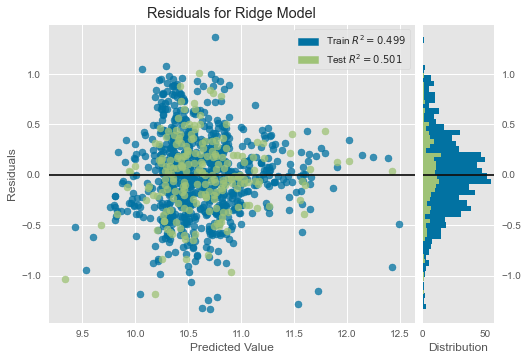

In [50]:
if model_type == "additive":
    x, y = prep_additive_model(data_matrix.fillna(0))
    if not include_impressions:
        x = x[get_media_vars(x)]
    model = ridge_regression(x, y)
elif model_type == "multiplicative":
    x, y = prep_mult_model(data_matrix.fillna(0))
    if not include_impressions:
        x = x[get_media_vars(x)]
    model = ridge_regression(x, y)

***

## model evaluation

Here's a graph of how well the model performs on the training set.
> MAPE = mean absolute percent error between the true revenue and predicted revenue (from trained model)

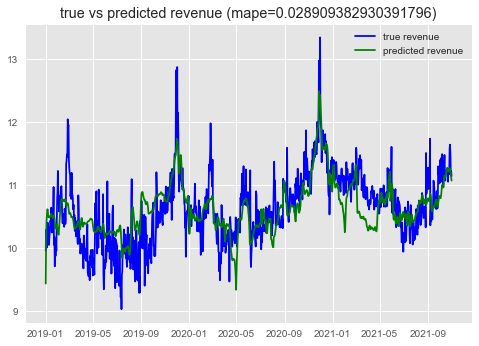

In [51]:
pred_vs_true(model, x, y)

### one-day forecasting

In [52]:
box, c = init_sliders(model)

In [53]:
box

Box(children=(HBox(children=(Label(value='AXM_MediaCost_alpha=0.9L=8theta=3_power=0.6'), IntSlider(value=0, ma…

Run the next cell. Verify that the specified slider values match the output.

In [54]:
get_slider_vals(model, c)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [55]:
if model_type == "additive":
    arr =  add_predict(data_dict[country].copy(), model, c)
elif model_type == "multiplicative":
    arr =  mult_predict(data_dict[country].copy(), model, c)

The input is  {'AXM': 0, 'Facebook': 0, 'Gear Patrol': 0, 'GearJunkie': 0, 'Outside Magazine': 0, 'Pinterest': 0, 'Search': 0, 'SnapChat': 0, 'Tetongravity': 0, 'Waze': 0, 'YouTube': 0}
The prediction in dollars is [53610.43204499]


### One-Month Forecasting

Run the next cell and proceed.

In [56]:
get_media_vars(x)

['AXM_MediaCost_alpha=0.9L=8theta=3_power=0.6',
 'Facebook_MediaCost_alpha=0.9L=4theta=0_power=0.6',
 'Gear Patrol_MediaCost_alpha=0.1L=26theta=24_power=0.6',
 'GearJunkie_MediaCost_alpha=0.6L=28theta=28_power=0.1',
 'Outside Magazine_MediaCost_alpha=0.1L=18theta=18_power=0.6',
 'Pinterest_MediaCost_alpha=0.4L=28theta=28_power=0.6',
 'Search_MediaCost_alpha=0.9L=4theta=2_power=0.6',
 'SnapChat_MediaCost_alpha=0.1L=2theta=0_power=0.1',
 'Tetongravity_MediaCost_alpha=0.9L=4theta=0_power=0.6',
 'Waze_MediaCost_alpha=0.9L=14theta=8_power=0.1',
 'YouTube_MediaCost_alpha=0.1L=2theta=0_power=0.6']

To forecast for one-month (or any time length greater than 1 day), write an excel spreadsheet or .csv file with the above columns in that **EXACT** order. Set `use_excel` to `True` if the file is an excel file, else set it to `False`.

In [57]:
data_type = "ad data [forecasting]"
use_excel = True

In [58]:
forecast_as_bytes = input_file(data_type, use_excel=use_excel)

FileUpload(value={}, accept='.xlsx', description='Upload')

In [44]:
forecast_sales_df = parse_file(forecast_as_bytes, data_type, use_excel=use_excel)

Thanks for uploading the ad data [forecasting]. I will display the dataframe in 2 seconds


,axm,facebook,gear patrol,gear junkie,outside magazine,pinterest media cost,search,snapchat,tetongravity,waze,youtube
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0


Is the header correct [y/n]y


,axm,facebook,gear patrol,gear junkie,outside magazine,pinterest media cost,search,snapchat,tetongravity,waze,youtube
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0


Type the letter y if the ad data [forecasting] file is good to go, OR the letter n if you'd like to reupload
proceed [y/n]y
SUCCESS -- PROCEED


In [ ]:
forecast_output_df = month_predict(forecast_sales_df.copy(), data_dict[country].copy(), model, model_type)

#### plot of predictions

Run the next cell to get a plot of predicted revenue for one month (or more) of forecasting. To export these predictions, see the bottom of this notebook for export options.

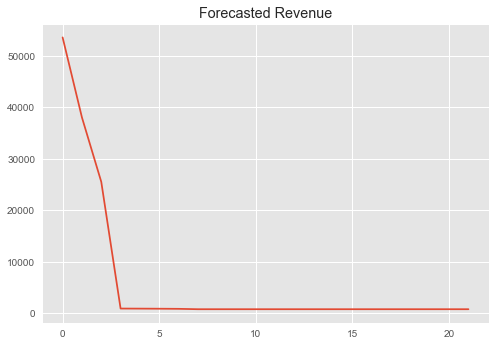

In [70]:
plt.plot(forecast_output_df.predictions)
plt.title("Forecasted Revenue");

***

<a id="optimize"></a> 
# 4) Optimization

We can use the training ridge regression model to optimize the mix. The optimizer can optimize the budget for a single day/week, and for a month. Run the next code cell to get a list of range sliders. Each slider can be adjusted accordingly to set the lower and upper bounds for each column. Then, run the rest of the cells. 

> Sometimes, the optimizer won't converge, due to either lack of data or lack of statistical significance.

## model for optimization

model=Ridge(alpha=1e-05, positive=True) train_r2=0.5666145715213308 validation_r2=0.5871280908790624


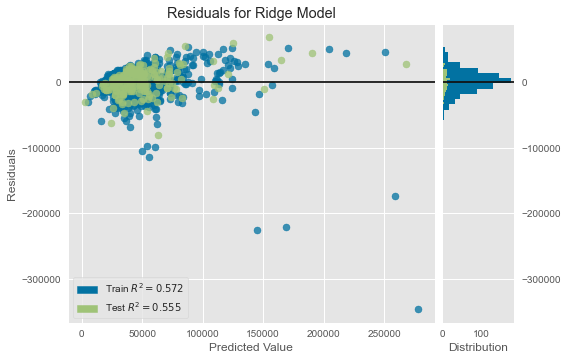

In [71]:
x, y = prep_additive_model(data_matrix.fillna(0))
x_opt = x[get_media_vars(x)]
model_opt = ridge_regression(x_opt, y)

## optimized budget - day

Run the next cell and set the lower and upper bounds appropriately by moving the cursors on the end. Unfortunately, there is no way to type values in as bounds, so be precise when setting the bounds.

> The one-day optimizer depends heavily on the past two weeks of data, so the one-day optimizer sometimes struggles to find meaningful results. This is corrected by the one-month+ optimizer.

In [72]:
dm2 = pd.concat([x_opt, y], axis=1)
bounds, a = set_bounds(model_opt)
bounds

Column
    [0] Markdown(str)
    [1] IntRangeSlider(end=50000, name='AXM_MediaCost_a_bounds', value=(0, 50000), value_end=50000)
    [2] Markdown(str)
    [3] IntRangeSlider(end=50000, name='Facebook_MediaC_bounds', value=(0, 50000), value_end=50000)
    [4] Markdown(str)
    [5] IntRangeSlider(end=50000, name='Gear Patrol_Med_bounds', value=(0, 50000), value_end=50000)
    [6] Markdown(str)
    [7] IntRangeSlider(end=50000, name='GearJunkie_Medi_bounds', value=(0, 50000), value_end=50000)
    [8] Markdown(str)
    [9] IntRangeSlider(end=50000, name='Outside Magazin_bounds', value=(0, 50000), value_end=50000)
    [10] Markdown(str)
    [11] IntRangeSlider(end=50000, name='Pinterest_Media_bounds', value=(0, 50000), value_end=50000)
    [12] Markdown(str)
    [13] IntRangeSlider(end=50000, name='Search_MediaCos_bounds', value=(0, 50000), value_end=50000)
    [14] Markdown(str)
    [15] IntRangeSlider(end=50000, name='SnapChat_MediaC_bounds', value=(0, 50000), value_end=50000)
    [16] Markdown(str)
    [17] IntRangeSlider(end=50000, name='Tetongravity_Me_bounds', value=(0, 50000), value_end=50000)
    [18] Markdown(str)
    [19] IntRangeSlider(end=50000, name='Waze_MediaCost__bounds', value=(0, 50000), value_end=50000)
    [20] Markdown(str)
    [21] IntRangeSlider(end=50000, name='YouTube_MediaCo_bounds', value=(0, 50000), value_end=50000)

In the next cell, edit the budget parameter by setting the value after `budget=` to whatever specified budget size you'd like. Then, run the cell.

In [73]:
b = add_optimize_budget(data_dict[country].copy(), dm2.copy(), model_opt, a, budget=30000)

Budget = $30000, Expected Revenue = $349869.6650906713


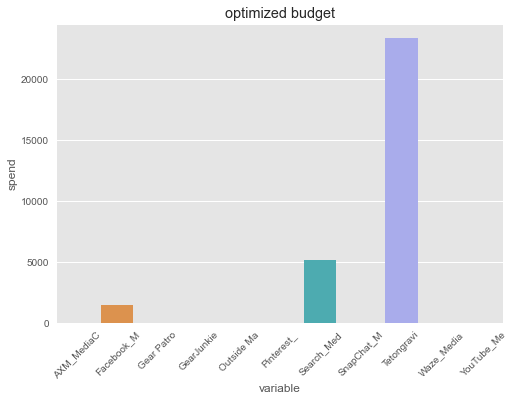

In [74]:
graph(b, 'optimized budget')

***

## optimized budget - month

To get the optimized budget for a month, run the next cell to get more bounds sliders. After that, run the next two cells, which will output a graph. To export the optimized budget to an excel spreadsheet, run the code under this section.

If the graph has low variance and values converge, the columns for which the spend converges are yet to be saturated. If the graph has high variance and values don't converge, under our assumptions, spend for the non-converging channels has reached saturation.

In [75]:
bounds

Column
    [0] Markdown(str)
    [1] IntRangeSlider(end=50000, name='AXM_MediaCost_a_bounds', value=(0, 50000), value_end=50000)
    [2] Markdown(str)
    [3] IntRangeSlider(end=50000, name='Facebook_MediaC_bounds', value=(0, 50000), value_end=50000)
    [4] Markdown(str)
    [5] IntRangeSlider(end=50000, name='Gear Patrol_Med_bounds', value=(0, 50000), value_end=50000)
    [6] Markdown(str)
    [7] IntRangeSlider(end=50000, name='GearJunkie_Medi_bounds', value=(0, 50000), value_end=50000)
    [8] Markdown(str)
    [9] IntRangeSlider(end=50000, name='Outside Magazin_bounds', value=(0, 50000), value_end=50000)
    [10] Markdown(str)
    [11] IntRangeSlider(end=50000, name='Pinterest_Media_bounds', value=(0, 50000), value_end=50000)
    [12] Markdown(str)
    [13] IntRangeSlider(end=50000, name='Search_MediaCos_bounds', value=(0, 50000), value_end=50000)
    [14] Markdown(str)
    [15] IntRangeSlider(end=50000, name='SnapChat_MediaC_bounds', value=(0, 50000), value_end=50000)
    [16] Markdown(str)
    [17] IntRangeSlider(end=50000, name='Tetongravity_Me_bounds', value=(0, 50000), value_end=50000)
    [18] Markdown(str)
    [19] IntRangeSlider(end=50000, name='Waze_MediaCost__bounds', value=(0, 50000), value_end=50000)
    [20] Markdown(str)
    [21] IntRangeSlider(end=50000, name='YouTube_MediaCo_bounds', value=(0, 50000), value_end=50000)

In [78]:
llb = add_optimize_month(data_dict[country].copy(), data_matrix.copy(), model_opt, col_to_slider=a, budget=3000)

Budget = $3000, Expected Revenue = $107051.08567061505
Budget = $3000, Expected Revenue = $107076.29541419572
Budget = $3000, Expected Revenue = $106253.357215437
Budget = $3000, Expected Revenue = $104694.99228721057
Budget = $3000, Expected Revenue = $104114.60995212043
Budget = $3000, Expected Revenue = $103727.21984089055
Budget = $3000, Expected Revenue = $103418.60579537238
Budget = $3000, Expected Revenue = $103076.71017264918
Budget = $3000, Expected Revenue = $103054.71596489754
Budget = $3000, Expected Revenue = $103061.17222090822
Budget = $3000, Expected Revenue = $103077.21196457311
Budget = $3000, Expected Revenue = $103094.19172895871
Budget = $3000, Expected Revenue = $103096.2793834845
Budget = $3000, Expected Revenue = $103090.34042687935
Budget = $3000, Expected Revenue = $103082.09393620395
Budget = $3000, Expected Revenue = $103075.32858924032
Budget = $3000, Expected Revenue = $103085.30709511723
Budget = $3000, Expected Revenue = $103714.9281069012
Budget = $3000

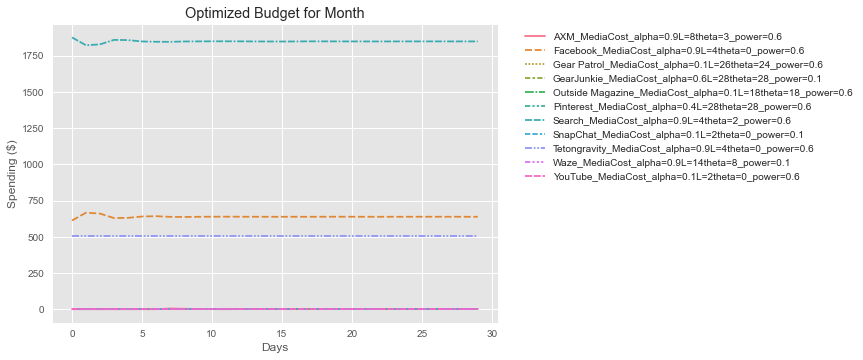

In [79]:
graph_month(llb, x_opt)

***
## Exports

### One-Month Forecasting

Add a unique file name into the string in the next cell, leaving out the file suffix. Then, run the cell after that to get a download link to the forecast. The Excel spreadsheet will have a new column containing the predictions.

In [81]:
unique_file_name = "SAAS_one_month_fcastA"

In [82]:
def export_month_forecasting(forecast_output_df, client, unique_file_name):
    forecast_output_df.to_excel(unique_file_name + ".xlsx", index=False)
    file = FileLink(unique_file_name + ".xlsx")
    display(file)
export_month_forecasting(forecast_output_df, client, unique_file_name)

C:\Users\Rishab\Documents\GitHub\saas-dc-mmww\proactiv\modeling\SAAS_one_month_fcastA.xlsx

### Optimized Month

Run this cell to get a download link to the optimized budget. This cell requires the optimized_budget - month section to be run.

In [83]:
def export_optimized_month(llb, x_opt, client):
    name = f"{client}_optimized_month.xlsx"
    pd.DataFrame(columns=[shorten_f_name(y) for y in x_opt.columns], data=np.array(llb)[:, :len(x_opt.columns)]).to_excel(name, index=False)
    file = FileLink(name)
    display(file)
export_optimized_month(llb, x_opt, client)

C:\Users\Rishab\Documents\GitHub\saas-dc-mmww\proactiv\modeling\MHW_optimized_month.xlsx

### Model Coefficients

Run this cell to get a download link to the model's coefficients.

In [85]:
def export_model_coefficients(model, client):
    name = f"{client}_model_coefficients.xlsx"
    model_coefficients = dict(zip([shorten_f_name(y) for y in model.feature_names_in_], model.coef_))
    pd.DataFrame(data=model_coefficients, index=[0]).to_excel(name, index=False)
    file = FileLink(name)
    display(file)

export_model_coefficients(model, client)

C:\Users\Rishab\Documents\GitHub\saas-dc-mmww\proactiv\modeling\MHW_model_coefficients.xlsx

This notebook was designed by __[SAAS Berkeley Data Consulting](https://saas.berkeley.edu/)__